In [ ]:
!pip3 install -r requirements.txt

In [1]:
import os
# os.environ['MUSDB_PATH'] = '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path

import sys
sys.path.append(os.path.abspath('../'))

In [2]:
import musdb

mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import musdb
import torch
import transforms
import utils
from mmdensenet import MMDenseNet
from datasets import STFTDataset, SamplingTrackDataset, FullTrackDataset
from tqdm.notebook import tqdm

torch.cuda.device_count()

1

In [7]:
seed = 42

torch.manual_seed(seed)
rng = np.random.default_rng(seed)

train_size, valid_size = 80, 14
sample_length_seconds = 5
sample_length_seconds_valid = 15
batch_size = 8
valid_batch_size = 8

training_data = SamplingTrackDataset(mus_train.tracks[:train_size], seconds=sample_length_seconds, target='vocals', rng=rng)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = FullTrackDataset(mus_valid.tracks[:valid_size], seconds=sample_length_seconds_valid, target='vocals')
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [8]:
in_channels, num_features = 2, 32

# growth_rate = [12,12,12,12,12,12,12]
growth_rate = [10,10,10,10,10,10,10]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
# depth = [4,4,4,4,4,4,4]
depth = [3,3,3,3,3,3,3]

growth_rate_final=4
kernel_size_final=3
depth_final=2
dilated_final=True
norm_final=True
nonlinear_final=True

model = MMDenseNet(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final)
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model)


Layer (type:depth-idx)                                            Param #
MMDenseNet                                                        --
├─BandSplit: 1-1                                                  --
├─ModuleDict: 1-2                                                 --
│    └─MDenseNetBackbone: 2-1                                     --
│    │    └─Conv2d: 3-1                                           608
│    │    └─Encoder: 3-2                                          22,544
│    │    └─DenseBlock: 3-3                                       5,520
│    │    └─Decoder: 3-4                                          26,010
│    └─MDenseNetBackbone: 2-2                                     --
│    │    └─Conv2d: 3-5                                           608
│    │    └─Encoder: 3-6                                          22,544
│    │    └─DenseBlock: 3-7                                       5,520
│    │    └─Decoder: 3-8                                          26,010
│    

In [9]:
epochs = 50
train_losses, valid_losses = [], []

for epoch in tqdm(range(epochs)):

    model.train()
    train_loss = []
    for i, (mixture, target) in enumerate(train_loader):

        optimizer.zero_grad()
        # magnitude, phase = torch.abs(mixture), torch.angle(mixture)
        # outputs = model(magnitude) * torch.exp(1j * phase)
        outputs = model(torch.abs(mixture))

        loss = loss_fn(outputs, torch.abs(target))
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (mixture, target) in enumerate(valid_loader):

                outputs = model(torch.abs(mixture))

                loss = loss_fn(outputs, torch.abs(target))
                valid_loss.append(loss.item())

        valid_loss = np.mean(valid_loss)
        valid_losses.append(valid_loss)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')
    else:
        print(f'epoch {epoch}: train loss {train_loss:3f}')

del outputs, loss

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 0: train loss 5.671075 valid loss 4.347191
epoch 1: train loss 3.658282
epoch 2: train loss 3.001574
epoch 3: train loss 3.234823
epoch 4: train loss 3.300407
epoch 5: train loss 2.611376
epoch 6: train loss 2.707001
epoch 7: train loss 2.466886
epoch 8: train loss 2.440719
epoch 9: train loss 2.121283 valid loss 2.388639
epoch 10: train loss 2.467980
epoch 11: train loss 2.140725
epoch 12: train loss 2.447450
epoch 13: train loss 1.968396
epoch 14: train loss 1.836158
epoch 15: train loss 1.953030
epoch 16: train loss 2.096539
epoch 17: train loss 1.871946
epoch 18: train loss 1.819910
epoch 19: train loss 2.265733 valid loss 2.181297
epoch 20: train loss 2.287327
epoch 21: train loss 1.986173
epoch 22: train loss 1.776985
epoch 23: train loss 1.876204
epoch 24: train loss 1.996295
epoch 25: train loss 1.789703
epoch 26: train loss 1.676024
epoch 27: train loss 1.764706
epoch 28: train loss 1.576979
epoch 29: train loss 1.906617 valid loss 1.540657
epoch 30: train loss 1.626298


In [10]:
model_path = os.path.join('../../models/mmdensenet', f'trained_model_epoch_{epochs}.pt')
torch.save(model.cpu().state_dict(), model_path)
torch.save(model.get_config(), os.path.join('../../models/mmdensenet', f'model_config.pt'))
print(f'Done, model saved at {model_path}')

Done, model saved at ../../models/mmdensenet/trained_model_epoch_50.pt


Matplotlib is building the font cache; this may take a moment.


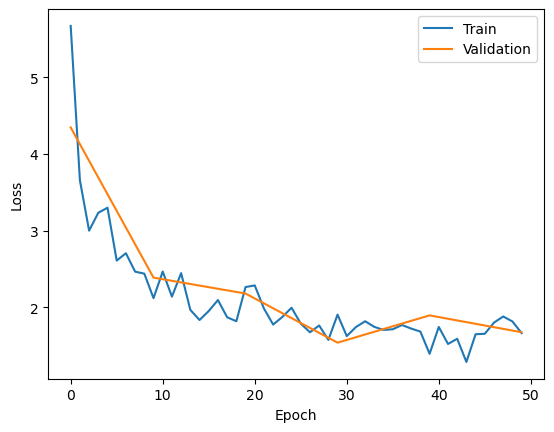

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot([0,9,19,29,39,49], valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [4]:
model = MMDenseNet.build_model('../../models/mmdensenet/model_config.pt')
model.load_state_dict(torch.load('../../models/mmdensenet/trained_model_epoch_50.pt'))
model.eval()

MMDenseNet(
  (bandsplit): BandSplit()
  (net): ModuleDict(
    (low): MDenseNetBackbone(
      (conv2d): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
      (encoder): Encoder(
        (net): Sequential(
          (0): DownSampleDenseBlock(
            (dense_block): DenseBlock(
              (net): Sequential(
                (0): ConvBlock2d(
                  (norm2d): BatchNorm2d(32, eps=1e-12, momentum=0.1, affine=True, track_running_stats=True)
                  (nonlinear2d): ReLU()
                  (conv2d): Conv2d(32, 30, kernel_size=(3, 3), stride=(1, 1))
                )
                (1): ConvBlock2d(
                  (norm2d): BatchNorm2d(10, eps=1e-12, momentum=0.1, affine=True, track_running_stats=True)
                  (nonlinear2d): ReLU()
                  (conv2d): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
                )
                (2): ConvBlock2d(
                  (norm2d): BatchNorm2d(10, eps=1e-12, momentum=0.1, affine=

In [ ]:
import scipy.io.wavfile

model.cuda()
model.eval()
sdrs = []
with torch.no_grad():
    for i, track in enumerate(mus_valid.tracks):
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 60., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))
        mixture_track = torch.cat(mixture_track, dim=1)
        target_track = torch.cat(target_track, dim=1)
        pred_track = torch.cat(pred_track, dim=1)
        sdr = signal_distortion_ratio(
            pred_track,
            target_track).cpu().numpy().flatten()
        sdrs.append(sdr)
        print(sdr)

        # scipy.io.wavfile.write(f'../audio_outputs/preds/{i}.wav', 44100, pred_track.numpy().T)
        # scipy.io.wavfile.write(f'../audio_outputs/mixtures/{i}.wav', 44100, mixture_track.numpy().T)
        # scipy.io.wavfile.write(f'../audio_outputs/targets/{i}.wav', 44100, target_track.numpy().T)

        # del pred_track, mixture_track, target_track

np.array(sdrs).mean()